In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time
import pickle
from imp import reload
from os.path import join

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from data_loader import DataLoader
import medim
reload(medim);

In [3]:
raw_path = '/home/mount/neuro-t01-hdd/Brats2017/data/raw/'

data_loader = DataLoader(raw_path)
patients = data_loader.patients

n_classes = 3

In [4]:
processed_path = '/mount/export/Brats2017/data/processed'
mscans = []
msegms = []

for patient in tqdm(patients):
    filename = join(processed_path, patient)
    
    mscans.append(np.load(filename+'_mscan.npy'))
    msegms.append(np.load(filename+'_segmentation.npy'))

100%|██████████| 285/285 [00:53<00:00,  3.55it/s]


In [4]:
n_splits = 50

cv = KFold(n_splits, shuffle=True, random_state=17)
train, val = next(cv.split(mscans))

def extract(l, idx):
    return [l[i] for i in idx]

mscans_train, mscans_val = extract(mscans, train), extract(mscans, val)
msegms_train, msegms_val = extract(msegms, train), extract(msegms, val)

In [5]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = 2*(kernel_size - 1)
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
    def forward(self, x):
        residual = torch.cat([x, Variable(torch.zeros(x.size())).cuda()], dim=1)
        size = residual.size()
        residual = residual[:,:self.out_channels,
                            :size[2]-self.padding, :size[3]-self.padding, :size[4]-self.padding]
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Model(nn.Module):
    def __init__(self, block, n_chans_path1, n_chans_path2, n_chans_common_part, kernel_size, num_classes=3):
        super(Model, self).__init__()
        in_channels = 4
        #path1
        self.conv1 = nn.Conv3d(in_channels, n_chans_path1[0], kernel_size, bias=False)
        self.bn1 = nn.BatchNorm3d(n_chans_path1[0])
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv3d(n_chans_path1[0], n_chans_path1[1], kernel_size, bias=False)
        self.bn2 = nn.BatchNorm3d(n_chans_path1[1])
        
        self.layer1 = block(n_chans_path1[1], n_chans_path1[2], kernel_size)
        self.layer2 = block(n_chans_path1[2], n_chans_path1[4], kernel_size)
        self.layer3 = block(n_chans_path1[4], n_chans_path1[6], kernel_size)
        
        #path2
        self.avg_pool = nn.AvgPool3d(3)
        self.conv3 = nn.Conv3d(in_channels, n_chans_path2[0], kernel_size, bias=False)
        self.bn3 = nn.BatchNorm3d(n_chans_path2[0])
        
        self.conv4 = nn.Conv3d(n_chans_path2[0], n_chans_path2[1], kernel_size, bias=False)
        self.bn4 = nn.BatchNorm3d(n_chans_path2[1])
        
        self.layer4 = block(n_chans_path2[1], n_chans_path2[2], kernel_size)
        self.layer5 = block(n_chans_path2[2], n_chans_path2[4], kernel_size)
        self.layer6 = block(n_chans_path2[4], n_chans_path2[6], kernel_size)
        
        
        self.convTr = torch.nn.ConvTranspose3d(n_chans_path2[6], n_chans_path2[8], kernel_size=5, 
                                               stride=3, padding=3)
        
        self.layer7 = block(n_chans_common_part[0], n_chans_common_part[2], 1)
        
        self.conv5 = nn.Conv3d(n_chans_common_part[2], n_chans_common_part[3], 1, bias=False)
        self.bn5 = nn.BatchNorm3d(n_chans_common_part[3])
        self.s = nn.Sigmoid()
        
    def forward(self, x, x_ext):
        out_path1 = self.conv1(x)
        out_path1 = self.bn1(out_path1)
        out_path1 = self.relu(out_path1)
        out_path1 = self.conv2(out_path1)
        out_path1 = self.bn2(out_path1)
        out_path1 = self.relu(out_path1)
        out_path1 = self.layer1(out_path1)
        out_path1 = self.layer2(out_path1)
        out_path1 = self.layer3(out_path1)
        
        out_path2 = self.avg_pool(x_ext)
        out_path2 = self.conv3(out_path2)
        out_path2 = self.bn3(out_path2)
        out_path2 = self.relu(out_path2)
        out_path2 = self.conv4(out_path2)
        out_path2 = self.bn4(out_path2)
        out_path2 = self.relu(out_path2)
        out_path2 = self.layer4(out_path2)
        out_path2 = self.layer5(out_path2)
        out_path2 = self.layer6(out_path2)
        out_path2 = self.convTr(out_path2)

        out = torch.cat([out_path1, out_path2], dim=1)
        
        out = self.layer7(out)
        out = self.conv5(out)
        out = self.bn5(out)
        out = self.s(out)
        return out

In [6]:
kernel_size = 3
n_chans_path1 = [30, 30, 40, 40, 40, 40, 50, 50]
n_chans_path2 = [30, 30, 40, 40, 40, 40, 50, 50, 50]
n_chans_common_part = [100, 150, 150, n_classes]

patch_size_x = np.array([25, 25, 25])
patch_size_x_ext = patch_size_x + 32
patch_size_y = patch_size_x - 2*(len(n_chans_path1))

model = Model(ResidualBlock, n_chans_path1, n_chans_path2,
              n_chans_common_part, kernel_size).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Model (
  (conv1): Conv3d(4, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (conv2): Conv3d(30, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  (bn2): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
  (layer1): ResidualBlock (
    (conv1): Conv3d(30, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
  )
  (layer2): ResidualBlock (
    (conv1): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(40, eps=1e-05, momentum=0.1,

In [7]:
padding = (patch_size_x - patch_size_y) // 2
padding_ext = (patch_size_x_ext - patch_size_y) // 2

def min_padding(mscan, padding):
    padding = np.array([0] + list(padding))
    padding = np.repeat(padding[:, None], 2, axis=1)
    
    return np.pad(mscan, padding, mode='minimum')

In [8]:
def pred_reshape(y):
    x = y.permute(0, 2, 3, 4, 1)
    return x.contiguous().view(-1, x.size()[-1])

def loss_cross_entropy(y_pred, y_true):
    return F.cross_entropy(pred_reshape(y_pred), y_true.view(-1))

def loss_binary_entropy(y_pred, y_true):
    return F.binary_cross_entropy(y_pred, y_true)

def to_var(x, volatile=False):
    return Variable(torch.from_numpy(x), volatile=volatile).cuda()

def to_numpy(x):
    return x.cpu().data.numpy()

coeff = to_var(np.array([1, 2, 3], dtype=np.float32))
epsilon = 1e-7

def dice_loss(y_pred, target):
    y_pred = y_pred.view(*y_pred.size()[:2], -1)
    target = target.view(*target.size()[:2], -1)
    
#     s = y_pred.size()
#     e = epsilon.expand(s[0], 1, s[2])
    dice_scores = 2 * (epsilon + (y_pred * target).sum(2)) / \
                  (y_pred.sum(2) + target.sum(2) + 2 * epsilon)
        
    dice_scores = dice_scores.mean(0)
    dice_scores = dice_scores.view(-1)

    return -torch.sum(dice_scores * coeff)

def dice_score(y_pred, target):
    """Dice score for binary segmentation on 3d scan"""
    return 2 * np.sum(y_pred * target) / (np.sum(y_pred) + np.sum(target))

In [9]:
def uniform_ext(mscans, msegms, *, batch_size, patch_size_x_ext, patch_size_x, patch_size_y):
    """Patch iterator with uniformed distribution over spatial dimensions"""
    assert np.all(patch_size_x % 2 == patch_size_y % 2)
    patch_size_pad = (patch_size_x - patch_size_y) // 2
    patch_size_pad_ext = (patch_size_x_ext - patch_size_y) // 2

    n = len(mscans)

    max_spatial_idy = np.array(
        [list(s.shape[1:]) for s in mscans]) - patch_size_y + 1

    x_batch_ext = np.zeros((batch_size, mscans[0].shape[0], *patch_size_x_ext), dtype=np.float32)
    x_batch = np.zeros((batch_size, mscans[0].shape[0], *patch_size_x), dtype=np.float32)
    y_batch = np.zeros((batch_size, msegms[0].shape[0], *patch_size_y), dtype=np.float32)

    while True:
        idy = np.random.randint(n, size=batch_size)
        start_idy = np.random.rand(batch_size, 3) * max_spatial_idy[idy]
        start_idy = np.int32(np.floor(start_idy))
        for i in range(batch_size):
            s = start_idy[i]
            slices = [...] + [slice(s[k], s[k] + patch_size_y[k]) for k in
                              range(3)]
            y_batch[i] = msegms[idy[i]][slices]

            s = start_idy[i] - patch_size_pad
            e = s + patch_size_x
            padding_l = [0] + [-s[i] if s[i] < 0 else 0 for i in range(s.shape[0])]
            padding_r = [0] + [-mscans[idy[i]].shape[k+1] + e[k] if e[k] >= mscans[idy[i]].shape[k+1] else 0 
                               for k in range(e.shape[0])]
            padding = list(zip(padding_l, padding_r))
            slices = [...] + [slice(max(s[k], 0), min(e[k], mscans[idy[i]].shape[k+1])) 
                              for k in range(3)]
            
            min_const = np.amin(mscans[idy[i]])
            x_batch[i] = np.pad(mscans[idy[i]][slices], padding, mode='constant', constant_values=min_const)
            
            s = start_idy[i] - patch_size_pad_ext
            e = s + patch_size_x_ext
            padding_l = [0] + [-s[i] if s[i] < 0 else 0 for i in range(s.shape[0])]
            padding_r = [0] + [-mscans[idy[i]].shape[k+1] + e[k] if e[k] >= mscans[idy[i]].shape[k+1] else 0 \
                               for k in range(e.shape[0])]
            padding = list(zip(padding_l, padding_r))
            slices = [...] + [slice(max(s[k], 0), min(e[k], mscans[idy[i]].shape[k+1])) 
                              for k in range(3)]
            
            min_const = np.amin(mscans[idy[i]])
            x_batch_ext[i] = np.pad(mscans[idy[i]][slices], padding, mode='constant', constant_values=min_const)
        yield np.array(x_batch_ext), np.array(x_batch), np.array(y_batch)

In [10]:
n_epoch = 100
batch_per_epoch = 40
batch_size = 64

for epoch in range(n_epoch):
    train_iter = uniform_ext(
        mscans_train, msegms_train, batch_size=batch_size, patch_size_x_ext=patch_size_x_ext,
        patch_size_x=patch_size_x, patch_size_y=patch_size_y, 
    )
    
    start_train = time.time()
    
    model.train()
    losses = []
    weights = []
    for _ in range(batch_per_epoch):
        x_batch_ext, x_batch, y_batch = next(train_iter)

        y_pred = model(to_var(x_batch), to_var(x_batch_ext))

        optimizer.zero_grad()
        loss = loss_binary_entropy(y_pred, to_var(y_batch))
        
        loss.backward()
        optimizer.step()

        losses.append(to_numpy(loss))
        weights.append(len(x_batch))
            
    train_loss = np.average(np.array(losses).flatten(), weights=weights)
    #train_acc = np.average(np.array(accs).flatten(), weights=weights)
    
    end_train = time.time()
    
    start_val = time.time()
    
    model.eval()
    losses = []
    dices = []
    for mscan, segm in tqdm(zip(mscans_val, msegms_val)):
        x_batch = min_padding(mscan, padding)[None, :]
        x_batch_ext = min_padding(mscan, padding_ext)[None, :]
        y_batch = np.array(segm[None, :], dtype=np.float32)
        print(x_batch.shape, x_batch_ext.shape)
        y_pred = model(to_var(x_batch, volatile=True), to_var(x_batch_ext, volatile=True))

        loss = loss_binary_entropy(y_pred, to_var(y_batch))

        y_pred = to_numpy(y_pred)
        dices.append([dice_score(y_pred[0, k] > 0.5, y_batch[0, k]) for k in range(n_classes)])
        losses.append(to_numpy(loss))
    
    end_val = time.time()
    
    val_loss = np.mean(np.array(losses).flatten())
    val_dices = np.mean(np.array(dices), axis=0)
    
    print('Epoch {}'.format(epoch))
    print('Train:', train_loss)
    print('Val  :', val_loss, val_dices)
    print('Time :', end_train - start_train, end_val - start_val)
    print('\n')

0it [00:00, ?it/s]

(1, 4, 152, 184, 158) (1, 4, 456, 552, 474)


RuntimeError: cuda runtime error (2) : out of memory at /py/conda-bld/pytorch_1493680494901/work/torch/lib/THC/generic/THCStorage.cu:66

In [10]:
model.eval()

Model (
  (conv1): Conv3d(4, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
  (relu1): ReLU (inplace)
  (conv2): Conv3d(30, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  (bn2): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
  (relu2): ReLU (inplace)
  (layer1): ResidualBlock (
    (conv1): Conv3d(30, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
  )
  (layer2): ResidualBlock (
    (conv1): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(4

In [15]:
y_predicted = []

for mscan, segm in tqdm(zip(mscans_val, msegms_val)):
    x_batch = min_padding(mscan, padding)[None, :]
    x_batch_ext = min_padding(mscan, (avg_pool_size-1)/2*x_batch.shape[2:] + padding)[None, :]
    y_batch = np.array(segm[None, :], dtype=np.float32)
    print(x_batch.shape, x_batch_ext.shape)
    y_pred = model(to_var(x_batch, volatile=True), to_var(x_batch_ext, volatile=True))


    y_predicted.append(to_numpy(y_pred)[0])


0it [00:00, ?it/s]


(1, 4, 152, 184, 158) (1, 4, 456, 552, 474)


TypeError: forward() missing 1 required positional argument: 'x_ext'

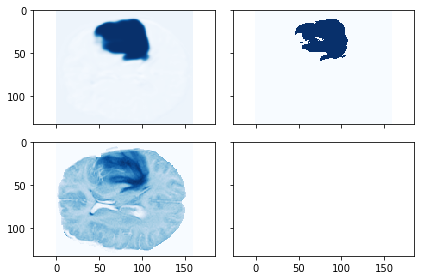

In [14]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

i = 1
k = 80

cmap = cm.Blues

ax[0, 0].imshow(y_predicted[i][0, ..., k], cmap=cmap)
#plt.colorbar()
#plt.show()
ax[0, 1].imshow(msegms_val[i][0, ..., k], cmap=cmap)
ax[1, 0].imshow(mscans_val[i][3, ..., k], cmap=cmap)
plt.tight_layout()
plt.show()
#plt.colorbar()
#plt.show()

In [13]:
plt.imshow(to_numpy(model(to_var(x_batch, volatile=True)))[0, 0, ..., 10])

RuntimeError: cuda runtime error (2) : out of memory at /py/conda-bld/pytorch_1493680494901/work/torch/lib/THC/THCGeneral.c:833

In [133]:
np.sum(e == np.zeros_like(e)) / np.prod(e.shape)

1.0

In [131]:
e = np.argmax(to_numpy(pred_reshape(y_pred)), axis=1)

In [134]:
e

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
def one_hot(x):
    enc = np.eye(n_classes)[x]
    return np.rollaxis(enc, 4, 1)

In [62]:
np.unique(y_batch, return_counts=True)

(array([0, 2]), array([6621,  669]))

In [67]:
np.all(one_hot(y_batch).sum(1) == 1)

True

In [113]:
a = one_hot(y_batch)

In [114]:
np.mean(np.argmax(a, axis=1) == y_batch)

1.0

In [112]:
a.shape

(10, 4, 9, 9, 9)

In [115]:
b = pred_reshape(to_var(a))

In [116]:
b.size()

torch.Size([7290, 4])

In [123]:
F.cross_entropy(b*10, to_var(y_batch.flatten()).long())

Variable containing:
1.00000e-04 *
  1.3619
[torch.cuda.DoubleTensor of size 1 (GPU 0)]

In [8]:
def to_vec(y):
    return y.reshape((1,))

In [79]:
y = np.arange(8).reshape((2,2,2))

In [12]:
x = Variable(torch.randn(2, 2))

In [13]:
x

Variable containing:
 1.2181 -0.1400
-1.0266  0.5286
[torch.FloatTensor of size 2x2]

In [13]:
y = Variable(torch.ones(2*3, 2*3))
y

Variable containing:
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
 1  1  1  1  1  1
[torch.FloatTensor of size 6x6]

In [14]:
x * y

RuntimeError: inconsistent tensor size at /py/conda-bld/pytorch_1493680494901/work/torch/lib/TH/generic/THTensorMath.c:846

In [62]:
y = Variable(torch.randn(2, 2))

In [67]:
torch.cat([y,y], dim=0)

Variable containing:
 0.4038  0.9883
 0.3989 -0.3968
 0.4038  0.9883
 0.3989 -0.3968
[torch.FloatTensor of size 4x2]

In [23]:
y = torch.zeros(4,4)
y


 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0
[torch.FloatTensor of size 4x4]

In [20]:
z = torch.cat((x,y), dim=0)

In [74]:
y.size() - 2

TypeError: unsupported operand type(s) for -: 'torch.Size' and 'int'

In [46]:
s = x.size()

In [37]:
a = x.permute(2, 0, 1).size()

In [54]:
s

torch.Size([2, 3, 5])

In [43]:
np.prod(a[:2])

10

In [52]:
x = x.view(int(np.prod((x.size()[:2]))), x.size()[-1])

In [53]:
x.size()

torch.Size([6, 5])